# Object detection using tensorflow api

The first step will be converting our data into a tensorflow record file, as described in these step-by-step instructions that I'm following: 
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_locally.md

### Converting our fashion data set into a tensorflow record file

Tutorial: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

In [1]:
import skimage.io as iosk
import matplotlib.pyplot as plt
%matplotlib inline

import hashlib
import io
import logging
import os
import random
import re

from lxml import etree
import numpy as np
import PIL.Image
import tensorflow as tf

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

image = '/Users/lisa/sandbox/iMaterialist_Challenge/data/tmm_dataset_sharing/image/92890.jpg'

/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


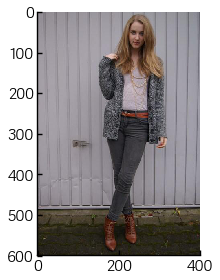

In [2]:
fashion_img = iosk.imread(image)
iosk.imshow(fashion_img)

In [3]:
fashion_string = fashion_img.tostring() # raw data bytes from a numpy array

actually first let's understand the file format for an example (pet) data set. we should have the images and then a mask

In [4]:
img_path = '/Users/lisa/Downloads/images/Abyssinian_1.jpg'
mask_path = '/Users/lisa/Downloads/annotations/trimaps/Abyssinian_1.png'

In [5]:
# simple example of how it should work
cat_img = iosk.imread(img_path)
# Let's convert the picture into string representation
# using the ndarray.tostring() function 
cat_string = cat_img.tostring()
print('cat string length', len(cat_string))
# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)

# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)

# Let's check if we got everything right and compare
# reconstructed array to the original one.
np.allclose(cat_img, reconstructed_cat_img)

cat string length 720000


/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


True

JPEG
32362
b'\x1e&\x1b\x1e&\x1b\x1e&\x1b\x1e'
b'\xff\xd8\xff\xe0\x00\x10JFIF'


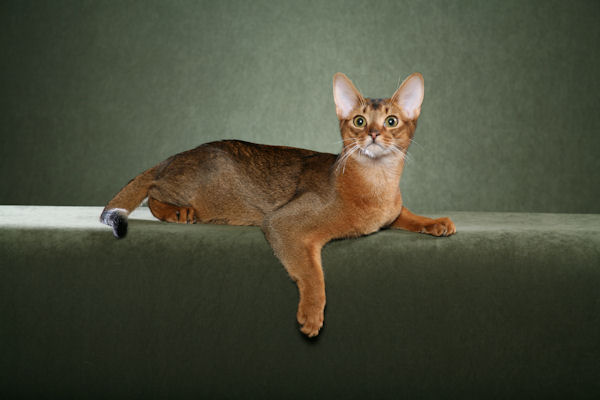

In [69]:
with tf.gfile.GFile(img_path, 'rb') as fid:
    encoded_jpg = fid.read(n=-1)
encoded_jpg_io = io.BytesIO(encoded_jpg)
image = PIL.Image.open(encoded_jpg_io)
image_np = np.asarray(image)
print(image.format)
print(len(encoded_jpg))
print(cat_string[:10])
print(encoded_jpg[:10])
image

In [70]:
with tf.gfile.GFile(mask_path, 'rb') as fid:
    encoded_mask_png = fid.read()
encoded_png_io = io.BytesIO(encoded_mask_png)
mask = PIL.Image.open(encoded_png_io)
print(mask.format)

PNG


In [71]:
mask_np = np.asarray(mask)
print(set(mask_np.flatten())) #make sure there are different values in this set.
print(np.shape(mask_np)) # the array is a numerical array that is the same size as the image. As expected.

{1, 2, 3}
(400, 600)


In [72]:
tfrecords_filename = 'pet_test.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)


In [73]:
height, width, rgb = np.shape(image_np)
print(height, width, rgb)

400 600 3


In [74]:
# the mask should have everything be zero that isn't the item of interest
#can put in loop if more than on label in image
masks = []
mask_remapped = (mask_np != 2).astype(np.uint8)
masks.append(mask_remapped)

In [75]:
encoded_mask_png_list = []
for mask in masks:
    img = PIL.Image.fromarray(mask)
    output = io.BytesIO()
    img.save(output, format='PNG')
    encoded_mask_png_list.append(output.getvalue())

In [76]:
# should also put the corresponding class name
feature_dict = {
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/mask': dataset_util.bytes_list_feature(encoded_mask_png_list)
}

example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
# print(example)

In [80]:
height = int(example.features.feature['image/height']
                                 .int64_list
                                 .value[0])

width = int(example.features.feature['image/width']
                            .int64_list
                            .value[0])

img_string = (example.features.feature['image/encoded']
                              .bytes_list
                              .value[0])

annotation_string = (example.features.feature['image/object/mask']
                            .bytes_list
                            .value[0])

img_1d = np.fromstring(img_string, dtype=np.uint8)
print(img_1d)
print(height)
print(width)
print(height*width*3)
reconstructed_img = img_1d.reshape((height, width, 3))

[255 216 255 ...   0 255 217]
400
600
720000


/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


ValueError: cannot reshape array of size 32362 into shape (400,600,3)

In [78]:
tf_example = example
writer.write(tf_example.SerializeToString())

In [79]:
writer.close()

I'm going to naively start with the same pipeline configuration as the pet training example.
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md

" In the object_detection/samples/configs folder, there are skeleton object_detection configuration files. We will use faster_rcnn_resnet101_pets.config as a starting point for configuring the pipeline. Open the file with your favourite text editor."

### Making tensorflow records file for the fashion dataset

In [9]:
import h5py
f = h5py.File('../data/tmm_dataset_sharing/fashon_parsing_data.hdf5', 'r')
data = f.get('#refs#')
keys = list(data.keys()) # each key has the data about an image

In [10]:
def rotate_seg_data(seg_data):
    rotated = np.rot90(seg_data)
    rotated = np.rot90(rotated)
    rotated = np.rot90(rotated)
    return rotated

In [11]:
def decode_color_category_labels(seg_data):
    '''Input is a segmented image. Output is the image with color or category labels'''
    
    seg_data = rotate_seg_data(seg_data)
    shape = np.shape(seg_data)
    pixels = seg_data.flatten()

    pix_colors = []
    pix_labels = []
    for pix in pixels:
        pix = int(pix)
        color = color_label[pix]-1 # off by 1 because these were originally matlab files
        label = category_label[pix]-1 #off by 1 because these were originally matlab files
        pix_colors.append(color)
        pix_labels.append(label)
        
    return pix_colors, pix_labels, shape

In [14]:
# write a function to do that tensorflow thing.
# for an individual image, we want to look at the category labels and create masks

def create_tf_example(img_path, categorized_array):
    img = iosk.imread(img_path)
    encoded_jpg = img.tostring()
    height, width, rgb = img.shape
    
    image_categories = list(set(categorized_array.flatten()))
    encoded_mask_png_list = []
    classes = []
    
    for cat in image_categories:
        mask_remapped = (categorized_array == cat).astype(np.uint8)
        img = PIL.Image.fromarray(mask_remapped)
        output = io.BytesIO()
        img.save(output, format='PNG')
        encoded_mask_png_list.append(output.getvalue())
        classes.append(int(cat))
        
    # from pet example
    # class_name = get_class_name_from_filename(data['filename'])
    #  classes_text.append(class_name.encode('utf8'))
    #  classes.append(label_map_dict[class_name])
        
    feature_dict = {
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/mask': dataset_util.bytes_list_feature(encoded_mask_png_list), 
      'image/object/class/label': dataset_util.int64_list_feature(classes),
        }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
        
    #encoded_jpg, encoded_mask_png_list, [height, width], image_categories
    
    return example

In [16]:
count = 0
tfrecords_filename = 'fashion_test.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)
BASE_IMAGE_PATH = '/Users/lisa/sandbox/iMaterialist_Challenge/data/tmm_dataset_sharing/image/'
for key in keys:
    if count<10:
        image_data = data.get(key)
        segment_data = image_data.get('segmentation').value
        color_label = image_data.get('color_label').value[0]
        category_label = image_data.get('category_label').value[0]
        img_numbers = image_data.get('img_name').value
        
        
        image_name = ''
        for num in img_numbers:
            image_name += chr(num[0])
        print(image_name)
        color_image_flattened, label_image_flattened, shape = decode_color_category_labels(segment_data)
        
        new_color_image = np.reshape(color_image_flattened, shape)
        new_label_image = np.reshape(label_image_flattened, shape)
        
        image_path = BASE_IMAGE_PATH + '{}'.format(image_name)
        tf_example = create_tf_example(image_path, new_label_image) #I'm using the label as the mask. 
        # note in this case that the label is not an image
        writer.write(tf_example.SerializeToString())

    count+=1
    
writer.close()

32160.jpg
600 400
categorized array  (600, 400)
169304.jpg
600 400
categorized array  (600, 400)
100221.jpg
600 400
categorized array  (600, 400)
102919.jpg
600 400
categorized array  (600, 400)
134447.jpg
600 400
categorized array  (600, 400)
103419.jpg
600 400
categorized array  (600, 400)
169934.jpg
600 400
categorized array  (600, 400)
180677.jpg
600 400
categorized array  (600, 400)
86159.jpg
600 400
categorized array  (600, 400)
38182.jpg
600 400
categorized array  (600, 400)


We have now saved a version of a tensorflow record file. Now what do we do with it?  On to step # 2!!

In [68]:
# let's look at how to read the files first
print(tf_example.features.feature['image/object/mask'].bytes_list.value[3])

                               

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x02X\x08\x00\x00\x00\x00i\x87\xefT\x00\x00\x04\xb9IDATx\x9c\xed\xdd\xdbv\xaaH\x14\x05P\xe8\xd1\xff\xff\xcb\xd5\x0f}b\x8e\x8a\\\xab\xa0X\xce\xf9\x92\xc4\x18\x94Z\xec\xba\x10\x95a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xad\xf1\xea\'\xd0\xd6\xdb\xee\x95\xc7\xede\xc7V6\xfc\xcd^\xd1\x81,\xed\xdc\xda\xf6\xfd\x14k\x0b\xff\xb4\xdb\xf4\xd5\xc6v\x07[\xc3\xc387\x90\x15\x8d\xb6\xb2]\xdf\xef\xd6\xb0B\xfem\xb7\xe9K59\x86\xcb\xcf\x86\xc7v\x91\x84\x8e!+wke\xb3\x8e\xcf\xf7~\xf9\xb1\xae\xcc@V\xef\xd5\xbaF\x1d_\xee\xfa\xb3\xf9\x16\x91D\x8e!-\x8e\xb22\xf1}\x8biCd \xeb\xed+\xa5\xdf\xbf\xaa\x1fIb [\x1ai\xcf`3~\xfc\xa1\x82\xd4YV#\x13\xcd_y\xc6\x95X!\x9blX\xae\x8c\x1f:\xa8\xaaE\x12\x18H\xf5n\xbd\xbc|m\xfa\x88y\x81\xb4\x9bb}\xder\xc5\xc7\xcc\x0b\xa4\xbe\xf1\xe9\xcb\xdc]*\x88\x0b\xa4\xf5

In [62]:
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

#     features = tf.parse_single_example(
#       serialized_example, features = {
#       'image/height': tf.FixedLenFeature([], tf.int64),
#       'image/width': tf.FixedLenFeature([], tf.int64),
#       'image/encoded': tf.FixedLenFeature([], tf.string),
#       'image/format': tf.FixedLenFeature([], tf.string),
#       'image/object/mask': tf.FixedLenFeature([], tf.string), 
#       'image/object/class/label': tf.FixedLenFeature([], tf.int64)
#     })

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'image/height': tf.FixedLenFeature([], tf.int64),
        'image/width': tf.FixedLenFeature([], tf.int64),
        'image/encoded': tf.FixedLenFeature([], tf.string),
        'image/object/mask': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].

    image = tf.decode_raw(features['image/encoded'], tf.uint8)
    #annotation = tf.decode_raw(features['image/object/mask'], tf.uint8)
    
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
#     annotation = tf.reshape(annotation, annotation_shape)
    
#     image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
#     annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
#     # Random transformations can be put here: right before you crop images
#     # to predefined size. To get more information look at the stackoverflow
#     # question linked above.
    
#     resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
    
#     resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
    
    
#     images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
#                                                  batch_size=2,
#                                                  capacity=30,
#                                                  num_threads=2,
#                                                  min_after_dequeue=10)
    
    return image, width

In [63]:
tfrecords_filename = 'fashion_test.tfrecords'
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

image

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, anno = sess.run([image, annotation])
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        iosk.imshow(img)
        iosk.show()

        #iosk.imshow(anno)
        #iosk.show()
    
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Run call was cancelled


InvalidArgumentError: Key: image/object/mask.  Can't parse serialized Example.
	 [[Node: ParseSingleExample_23/ParseSingleExample = ParseSingleExample[Tdense=[DT_STRING, DT_INT64, DT_STRING, DT_INT64], dense_keys=["image/encoded", "image/height", "image/object/mask", "image/width"], dense_shapes=[[], [], [], []], num_sparse=0, sparse_keys=[], sparse_types=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"](ReaderReadV2_24:1, ParseSingleExample_23/Const, ParseSingleExample_23/Const_1, ParseSingleExample_23/Const, ParseSingleExample_23/Const_1)]]

Caused by op 'ParseSingleExample_23/ParseSingleExample', defined at:
  File "/Users/lisa/.pyenv/versions/3.6.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/lisa/.pyenv/versions/3.6.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/lisa/.pyenv/versions/3.6.0/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Users/lisa/.pyenv/versions/3.6.0/lib/python3.6/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/Users/lisa/.pyenv/versions/3.6.0/lib/python3.6/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-1b1b05e99001>", line 7, in <module>
    image, annotation = read_and_decode(filename_queue)
  File "<ipython-input-62-6ab9e5354d0b>", line 24, in read_and_decode
    'image/object/mask': tf.FixedLenFeature([], tf.string)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/ops/parsing_ops.py", line 758, in parse_single_example
    return parse_single_example_v2(serialized, features, name)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/ops/parsing_ops.py", line 1282, in parse_single_example_v2
    dense_defaults, dense_shapes, name)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/ops/parsing_ops.py", line 1399, in _parse_single_example_v2_raw
    name=name)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/ops/gen_parsing_ops.py", line 601, in parse_single_example
    sparse_types=sparse_types, dense_shapes=dense_shapes, name=name)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Key: image/object/mask.  Can't parse serialized Example.
	 [[Node: ParseSingleExample_23/ParseSingleExample = ParseSingleExample[Tdense=[DT_STRING, DT_INT64, DT_STRING, DT_INT64], dense_keys=["image/encoded", "image/height", "image/object/mask", "image/width"], dense_shapes=[[], [], [], []], num_sparse=0, sparse_keys=[], sparse_types=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"](ReaderReadV2_24:1, ParseSingleExample_23/Const, ParseSingleExample_23/Const_1, ParseSingleExample_23/Const, ParseSingleExample_23/Const_1)]]
